In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path


# Config
# Choose how to compute annual growth for index/level series:
#   "eop"  = end-of-period (Q4/Q4 for quarterly, Dec/Dec for monthly) since it is a stress test
GROWTH_METHOD = "eop"  

# Set up paths
base = Path("/mortgage risk app/") # Change to your own local path before running the code!
pudb_path = base / "2024_pudb_sf_nfa_fnma.csv"

mortgage_path = base / "MORTGAGE30US.csv"
hpi_path      = base / "HPI.csv"
unrate_path   = base / "UNRATE.csv"
gdp_path      = base / "GDP.csv"
cpi_path      = base / "CPIAUCSL.csv"

out_macro_path = base / "macro_annual_fred.csv"


# Helpers
def load_fred(path: Path, series_hint: str = None) -> pd.DataFrame:
    """
    Load a FRED CSV robustly. Handles:
      - DATE vs observation_date
      - VALUE vs named series column
    Returns columns: ['DATE', '<VALUE COL>'] with DATE as datetime.
    """
    df = pd.read_csv(path)
    # Detect date column
    date_col = None
    for cand in ["DATE", "observation_date", "date"]:
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        raise ValueError(f"No date column found in {path.name}")

    # Detect value column
    value_cols = [c for c in df.columns if c != date_col]
    if len(value_cols) == 0:
        raise ValueError(f"No value column found in {path.name}")

    # Prefer a series matching the hint if present
    if series_hint and series_hint in value_cols:
        val_col = series_hint
    else:
        # Fallback: if 'VALUE' exists, use it; else use the only/first remaining column
        if "VALUE" in value_cols:
            val_col = "VALUE"
        else:
            val_col = value_cols[0]

    # Parse
    out = df[[date_col, val_col]].copy()
    out.rename(columns={date_col: "DATE", val_col: val_col}, inplace=True)
    out["DATE"] = pd.to_datetime(out["DATE"])
    # Force numeric, coerce bad strings (e.g., ".")
    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    out = out.dropna(subset=[val_col])
    return out.rename(columns={val_col: series_hint if series_hint else val_col})


def annual_mean(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Annual mean for rate-type series (e.g., MORTGAGE30US, UNRATE)."""
    tmp = df.copy()
    tmp["YEAR"] = tmp["DATE"].dt.year
    return tmp.groupby("YEAR", as_index=False)[col].mean()


def annual_growth(df: pd.DataFrame, col: str, freq: str) -> pd.DataFrame:
    """
    Annual YoY % change for index/level series (GDP, HPI, CPI).
    - freq: 'M' for monthly, 'Q' for quarterly (used only if GROWTH_METHOD='eop')
    - GROWTH_METHOD='avg' uses % change of annual average
    - GROWTH_METHOD='eop' uses end-of-period (Dec/Dec for monthly, Q4/Q4 for quarterly)
    """
    tmp = df.copy()
    if GROWTH_METHOD == "avg":
        tmp["YEAR"] = tmp["DATE"].dt.year
        annual_avg = tmp.groupby("YEAR", as_index=False)[col].mean()
        annual_avg[col + "_GROWTH"] = annual_avg[col].pct_change() * 100
        return annual_avg[["YEAR", col + "_GROWTH"]]
    else:
        # End-of-period approach
        if freq.upper() == "M":
            tmp["YEAR"] = tmp["DATE"].dt.year
            tmp["MONTH"] = tmp["DATE"].dt.month
            # keep December observations
            eop = tmp[tmp["MONTH"] == 12].copy()
            eop = eop.sort_values("DATE")
            eop[col + "_GROWTH"] = eop[col].pct_change() * 100
            return eop[["YEAR", col + "_GROWTH"]]
        elif freq.upper() == "Q":
            # Identify 4th quarter as end-of-period
            tmp["YEAR"] = tmp["DATE"].dt.year
            tmp["QTR"] = tmp["DATE"].dt.quarter
            eop = tmp[tmp["QTR"] == 4].copy()
            # If a year is missing Q4, fallback to the last available quarter of that year
            if eop["YEAR"].nunique() < tmp["YEAR"].nunique():
                # take last obs per year as fallback
                last_per_year = tmp.sort_values("DATE").groupby("YEAR").tail(1)
                eop = pd.concat([eop, last_per_year]).drop_duplicates(subset=["YEAR"], keep="first")
                eop = eop.sort_values("YEAR")
            eop[col + "_GROWTH"] = eop[col].pct_change() * 100
            return eop[["YEAR", col + "_GROWTH"]]
        else:
            raise ValueError("freq must be 'M' or 'Q'")


# Load PUDB (for later merge)
df_pudb = pd.read_csv(pudb_path)

# Load FRED series
mortgage = load_fred(mortgage_path, series_hint="MORTGAGE30US")  # weekly
unrate   = load_fred(unrate_path,   series_hint="UNRATE")        # monthly
hpi      = load_fred(hpi_path,      series_hint="USSTHPI")       # quarterly
gdp      = load_fred(gdp_path,      series_hint="GDP")           # quarterly
cpi      = load_fred(cpi_path,      series_hint="CPIAUCSL")      # monthly


# Annual transforms
# Rates → annual mean
mortgage_annual = annual_mean(mortgage, "MORTGAGE30US")
unrate_annual   = annual_mean(unrate,   "UNRATE")

# Indexes/levels → YoY % change
hpi_annual  = annual_growth(hpi, "USSTHPI", freq="Q").rename(columns={"USSTHPI_GROWTH": "HPI_CHANGE"})
gdp_annual  = annual_growth(gdp, "GDP",     freq="Q").rename(columns={"GDP_GROWTH": "GDP_GROWTH"})
cpi_annual  = annual_growth(cpi, "CPIAUCSL",freq="M").rename(columns={"CPIAUCSL_GROWTH": "CPI_GROWTH"})


# Merge macro panel
macro = (
    mortgage_annual
    .merge(unrate_annual, on="YEAR", how="outer")
    .merge(gdp_annual,    on="YEAR", how="outer")
    .merge(hpi_annual,    on="YEAR", how="outer")
    .merge(cpi_annual,    on="YEAR", how="outer")
    .sort_values("YEAR")
    .reset_index(drop=True)
)

macro.to_csv(out_macro_path, index=False)
print(f"Saved annual macro table to: {out_macro_path}")


# Stress dictionary (annual deltas)
# Keeping these as deltas to apply to macro columns after merge with PUDB (by YEAR).
stress = {
    "low": {"UNRATE": +2.0, "HPI_CHANGE": -10.0, "MORTGAGE30US": +1.0},
    "adverse":  {"UNRATE": +5.0, "HPI_CHANGE": -20.0, "MORTGAGE30US": +2.0}
}


In [3]:
# Add YEAR to PUDB (Single-Family National File A is per acquisition year) 
# file is the 2024 release, set YEAR=2024 for all rows:
df_pudb["YEAR"] = 2024

# Merge PUDB with the macro panel on YEAR
macro = pd.read_csv(out_macro_path)
df = df_pudb.merge(macro, on="YEAR", how="left")

In [4]:
# Ensure the categorical code columns exist; skip missing ones safely
def exists(c): return c in df.columns

# Simple, interpretable proxy: higher LTV + lower borrower/tract income => higher risk
risk_terms = []
if exists("ltv_cat"):
    risk_terms.append(df["ltv_cat"].astype(float))
if exists("income_cat"):
    # higher income_cat assumed safer → invert
    risk_terms.append(1.0 / df["income_cat"].replace(0, np.nan).astype(float))
if exists("tract_income_cat"):
    # higher tract income assumed safer → invert
    risk_terms.append(1.0 / df["tract_income_cat"].replace(0, np.nan).astype(float))

if len(risk_terms) == 0:
    df["risk_index"] = 0.0
else:
    df["risk_index"] = np.nanmean(np.vstack(risk_terms), axis=0)

# Binary target: top decile = HIGH_RISK
thr = df["risk_index"].quantile(0.90)
df["HIGH_RISK"] = (df["risk_index"] >= thr).astype(int)

In [ ]:
# Anti-overfitting + target

USE_NOISY_TARGET = True   # set False to use df["HIGH_RISK"] directly
NOISE_STD = 0.35          # 0.2–0.6 reasonable

# Features (exclude the ones used to build HIGH_RISK)
leakage_feats = ["ltv_cat", "income_cat", "tract_income_cat"]
candidate_feats = [
    # loan-level NOT used in target construction
    "tract_minority_cat", "purpose_sf_nfa", "fed_guarantee_sf_nfa", "afford_sf",
    # macro
    "UNRATE", "MORTGAGE30US", "GDP_GROWTH", "HPI_CHANGE", "CPI_GROWTH"
]
features = [c for c in candidate_feats if c in df.columns]

# Target
if USE_NOISY_TARGET and "risk_index" in df.columns:
    rng = np.random.default_rng(42)
    noisy = df["risk_index"].astype(float) + rng.normal(0.0, NOISE_STD, len(df))
    thr = df["risk_index"].quantile(0.90)
    y = (noisy >= thr).astype(int)
else:
    y = df["HIGH_RISK"].astype(int)

# Design matrix
X = df[features].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median(numeric_only=True))

# Split to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Model factory (no early stopping to keep CV simple)
def build_base_model():
    """Return an unfitted classifier; prefer LightGBM, else HistGBM, else LogisticRegression."""
    try:
        import lightgbm as lgb
        return lgb.LGBMClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            num_leaves=31,
            min_child_samples=200,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_lambda=1.0,    # L2
            reg_alpha=0.5,     # L1
            random_state=42
        )
    except Exception:
        try:
            from sklearn.ensemble import HistGradientBoostingClassifier
            return HistGradientBoostingClassifier(
                learning_rate=0.05,
                max_depth=3,
                max_leaf_nodes=31,
                min_samples_leaf=200,
                l2_regularization=1.0,
                random_state=42
            )
        except Exception:
            from sklearn.linear_model import LogisticRegression
            return LogisticRegression(
                max_iter=1000,
                C=0.5,
                penalty="l2",
                class_weight="balanced",
                solver="lbfgs",
                random_state=42
            )

# Fit base model & holdout AUC
from sklearn.metrics import roc_auc_score

model = build_base_model()
model.fit(X_train, y_train)
baseline_pred = model.predict_proba(X_test)[:, 1]
print("Holdout AUC:", roc_auc_score(y_test, baseline_pred))

# Probability calibration (isotonic CV)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import brier_score_loss

cal = CalibratedClassifierCV(
    estimator=build_base_model(),  # unfitted, same family
    method="isotonic",
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)
cal.fit(X_train, y_train)

p_cal_baseline = cal.predict_proba(X_test)[:, 1]
print("AUC (calibrated):", roc_auc_score(y_test, p_cal_baseline))
print("Brier (calibrated):", brier_score_loss(y_test, p_cal_baseline))
print("Mean predicted prob (baseline, calibrated):", p_cal_baseline.mean())

# 5-fold CV AUC (un-calibrated base model)
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(build_base_model(), X, y, cv=cv, scoring="roc_auc")
print("5-fold CV AUC: mean =", cv_auc.mean().round(4), ", std =", cv_auc.std().round(4))

# Keeping both versions: relative vs realistic (anchored)
def shift_to_base_rate(p, target_rate):
    """Re-anchor probabilities to match a chosen portfolio-level PD."""
    eps = 1e-9
    p = np.clip(p, eps, 1 - eps)
    logit = np.log(p / (1 - p))
    p_hat = p.mean()
    shift = np.log(target_rate / (1 - target_rate)) - np.log(p_hat / (1 - p_hat))
    return 1 / (1 + np.exp(-(logit + shift)))

# 1) Relative PDs (calibrated to prevalence)
p_baseline_rel = p_cal_baseline.copy()

# 2) Realistic PDs (anchored to a chosen base rate, e.g., 2%)
TARGET_BASE_PD = 0.02
p_baseline_real = shift_to_base_rate(p_cal_baseline, TARGET_BASE_PD)
print("Means → relative:", p_baseline_rel.mean(), "| realistic (anchored):", p_baseline_real.mean())


# Stress test configuration
# Use macro std devs from the historical FRED data
macro = pd.read_csv(out_macro_path)
su  = macro["UNRATE"].std(ddof=1)
sh  = macro["HPI_CHANGE"].std(ddof=1)
sr  = macro["MORTGAGE30US"].std(ddof=1)

# Sensitivity weights (elasticities in log-odds space)
wu, wh, wr = 0.10, 0.07, 0.10   # tweaking possible

def odds_scaled_pd_adjust_from_probs(p, delta, su, sh, sr, wu=wu, wh=wh, wr=wr):
    """Adjust PDs given macro deltas, scaling by historical std devs, on log-odds scale."""
    zu = delta.get("UNRATE", 0.0)       / (su if su else 1.0)
    zh = delta.get("HPI_CHANGE", 0.0)   / (sh if sh else 1.0)
    zr = delta.get("MORTGAGE30US", 0.0) / (sr if sr else 1.0)
    shift = (wu*zu) + (-wh*zh) + (wr*zr)   # negative sign on HPI: declines raise PDs
    eps = 1e-9
    logit = np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps))
    p_new = 1 / (1 + np.exp(-(logit + shift)))
    return np.clip(p_new, 0.001, 0.99)

def run_scenarios(p0, stress, su, sh, sr, wu=wu, wh=wh, wr=wr):
    out = {"baseline": float(p0.mean())}
    for name, deltas in stress.items():
        p_s = odds_scaled_pd_adjust_from_probs(p0, deltas, su, sh, sr, wu=wu, wh=wh, wr=wr)
        out[name] = float(p_s.mean())
    return out

# Define your scenario shocks (in actual percentage-point units)
stress = {
    "low":     {"UNRATE": +2.0, "HPI_CHANGE": -10.0, "MORTGAGE30US": +1.0},
    "adverse": {"UNRATE": +5.0, "HPI_CHANGE": -20.0, "MORTGAGE30US": +2.0}
}

# Run scenarios for both versions
res_rel  = run_scenarios(p_baseline_rel,  stress, su, sh, sr)
res_real = run_scenarios(p_baseline_real, stress, su, sh, sr)

print("\nAverage predicted PD by scenario — RELATIVE (calibrated, ~prevalence):")
for k,v in res_rel.items():
    print(f"{k:8s}: {v:.3%}" + ("" if k=='baseline' else f"  (Δ: {v - res_rel['baseline']:+.3%})"))

print("\nAverage predicted PD by scenario — REALISTIC (anchored to {:.1%}):".format(TARGET_BASE_PD))
for k,v in res_real.items():
    print(f"{k:8s}: {v:.3%}" + ("" if k=='baseline' else f"  (Δ: {v - res_real['baseline']:+.3%})"))




Holdout AUC: 0.6970554943487348
AUC (calibrated): 0.6970557629861367
Brier (calibrated): 0.09144266880175778
Mean predicted prob (baseline, calibrated): 0.11122920159691779
5-fold CV AUC: mean = 0.6942 , std = 0.0008
Means → relative: 0.11122920159691779 | realistic (anchored): 0.021590411615489667

Average predicted PD by scenario — RELATIVE (calibrated, ~prevalence):
baseline: 11.123%
low     : 14.244%  (Δ: +3.121%)
adverse : 18.841%  (Δ: +7.718%)

Average predicted PD by scenario — REALISTIC (anchored to 2.0%):
baseline: 2.159%
low     : 2.893%  (Δ: +0.734%)
adverse : 4.084%  (Δ: +1.925%)


In [ ]:
# Baseline comparison
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a simple linear baseline
# using a scaler because Logistic Regression requires scaled data to perform well
baseline_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)

baseline_lr.fit(X_train, y_train)
lr_probs = baseline_lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)

# Get main model's AUC
main_model_auc = roc_auc_score(y_test, baseline_pred)

print(f"\n--- BENCHMARK RESULTS ---")
print(f"Main Model (Gradient Boosting) AUC: {main_model_auc:.4f}")
print(f"Baseline (Logistic Regression) AUC: {lr_auc:.4f}")
print(f"-------------------------\n")


--- BENCHMARK RESULTS ---
Main Model (Gradient Boosting) AUC: 0.6971
Baseline (Logistic Regression) AUC: 0.6910
-------------------------



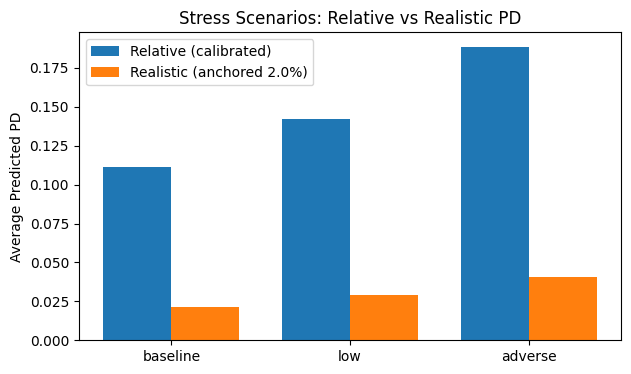

In [ ]:
# Visualization: side-by-side bars
# Generates Fig. 2 in report

import matplotlib.pyplot as plt
labels = list(res_real.keys())
vals_rel  = [res_rel[k]  for k in labels]
vals_real = [res_real[k] for k in labels]

plt.figure(figsize=(7,4))
w = 0.38
x = np.arange(len(labels))
plt.bar(x - w/2, vals_rel,  width=w, label="Relative (calibrated)")
plt.bar(x + w/2, vals_real, width=w, label=f"Realistic (anchored {TARGET_BASE_PD:.1%})")
plt.xticks(x, labels)
plt.ylabel("Average Predicted PD")
plt.title("Stress Scenarios: Relative vs Realistic PD")
plt.legend()
plt.show()

Driver impacts — RELATIVE:
         driver    avg_PD  delta_pp
2    Rate +1pp  0.114144  0.002915
0  UNRATE +2pp  0.122932  0.011703
1    HPI  -10%  0.126023  0.014794

Driver impacts — REALISTIC:
         driver    avg_PD  delta_pp
2    Rate +1pp  0.022251  0.000661
0  UNRATE +2pp  0.024273  0.002683
1    HPI  -10%  0.024995  0.003405


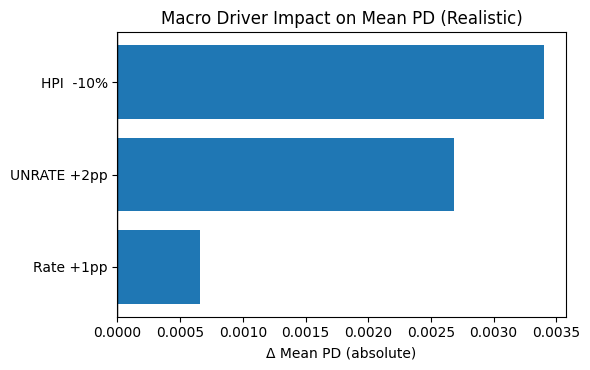

In [ ]:
# Macro Driver Sensitivity
# Fig 3 in report
# Table 1 in report

def driver_impact_table(p0, su, sh, sr, shocks):
    base = p0.mean()
    rows = []
    for name, delta in shocks.items():
        p_s = odds_scaled_pd_adjust_from_probs(p0, delta, su, sh, sr)
        rows.append({"driver": name, "avg_PD": p_s.mean(), "delta_pp": p_s.mean()-base})
    return pd.DataFrame(rows).sort_values("delta_pp", ascending=True)

# One-at-a-time shocks
driver_shocks = {
    "UNRATE +2pp":     {"UNRATE": +2.0},
    "HPI  -10%":       {"HPI_CHANGE": -10.0},
    "Rate +1pp":       {"MORTGAGE30US": +1.0}
}

tbl_rel  = driver_impact_table(p_baseline_rel,  su, sh, sr, driver_shocks)
tbl_real = driver_impact_table(p_baseline_real, su, sh, sr, driver_shocks)

print("Driver impacts — RELATIVE:\n", tbl_rel)
print("\nDriver impacts — REALISTIC:\n", tbl_real)

# Tornado chart (realistic)
plt.figure(figsize=(6,3.8))
y = np.arange(len(tbl_real))
plt.barh(y, tbl_real["delta_pp"], tick_label=tbl_real["driver"])
plt.axvline(0, color="k", linewidth=1)
plt.title("Macro Driver Impact on Mean PD (Realistic)")
plt.xlabel("Δ Mean PD (absolute)")
plt.tight_layout(); plt.show()


In [ ]:
# Segment Stress: which loans hurt the most?
# Table 2,3,4 in report

def segment_stress_table(p0, seg_col, stress_dict, su, sh, sr):
    out = []
    for seg, idx in df.loc[X_test.index].groupby(seg_col).indices.items():
        p_base_seg = p0[idx]
        row = {"segment": seg, "baseline": p_base_seg.mean()}
        for name, delta in stress_dict.items():
            p_s = odds_scaled_pd_adjust_from_probs(p_base_seg, delta, su, sh, sr)
            row[name] = p_s.mean()
            row[f"Δ_{name}"] = row[name] - row["baseline"]
        out.append(row)
    return pd.DataFrame(out).sort_values(f"Δ_{list(stress_dict.keys())[-1]}", ascending=False)

# Example with LTV and borrower income categories
for seg in [c for c in ["ltv_cat","income_cat","afford_sf"] if c in df.columns]:
    print(f"\nSegment stress by {seg} (REALISTIC PD):")
    seg_tbl = segment_stress_table(p_baseline_real, seg, stress, su, sh, sr)
    print(seg_tbl)



Segment stress by ltv_cat (REALISTIC PD):
   segment  baseline       low     Δ_low   adverse  Δ_adverse
4        5  0.036960  0.049166  0.012206  0.068625   0.031666
3        4  0.025515  0.034199  0.008685  0.048311   0.022796
2        3  0.024027  0.032222  0.008195  0.045554   0.021527
1        2  0.020155  0.027058  0.006902  0.038316   0.018161
0        1  0.013390  0.017976  0.004586  0.025459   0.012069

Segment stress by income_cat (REALISTIC PD):
   segment  baseline       low     Δ_low   adverse  Δ_adverse
3        9  0.046334  0.061159  0.014825  0.084284   0.037950
0        1  0.045593  0.060117  0.014524  0.082748   0.037155
1        2  0.029084  0.038741  0.009657  0.054181   0.025097
2        3  0.016940  0.022861  0.005922  0.032642   0.015702

Segment stress by afford_sf (REALISTIC PD):
   segment  baseline       low     Δ_low   adverse  Δ_adverse
2        2  0.077414  0.101200  0.023786  0.137396   0.059982
1        1  0.067048  0.088523  0.021475  0.122029   0.05498

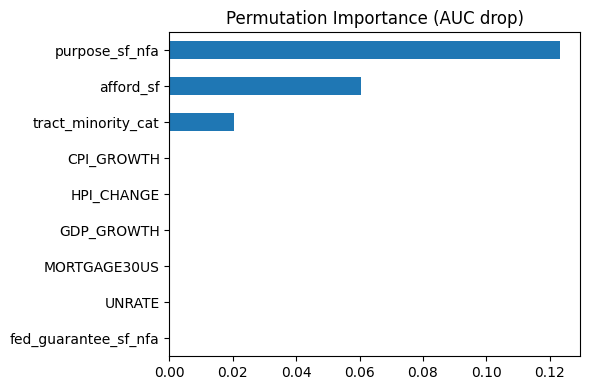

In [ ]:
# Feature Importance + Permutation Importance
# Fig 1 in report

from sklearn.inspection import permutation_importance

# Tree-based importance if available
try:
    imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(6,4))
    imp.tail(12).plot(kind="barh")
    plt.title("Model Feature Importance (Tree-based)")
    plt.tight_layout(); plt.show()
except Exception:
    pass

# Model-agnostic: permutation importance on held-out set
pi = permutation_importance(model, X_test, y_test, scoring="roc_auc", n_repeats=5, random_state=42)
pi_ser = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(6,4))
pi_ser.tail(12).plot(kind="barh")
plt.title("Permutation Importance (AUC drop)")
plt.tight_layout(); plt.show()

In [ ]:
# Borrower archetypes
# Table 5 in report

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_cols = [c for c in ["ltv_cat","income_cat","tract_income_cat","afford_sf"] if c in df.columns]
Z = df.loc[X_test.index, cluster_cols].astype(float).copy()
Z = StandardScaler().fit_transform(Z)

k = 4
km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(Z)
labels_k = km.labels_

# Attach PDs
tmp = pd.DataFrame({
    "cluster": labels_k,
    "PD_base": p_baseline_real,
    "PD_low":  odds_scaled_pd_adjust_from_probs(p_baseline_real, stress["low"], su, sh, sr),
    "PD_adv":  odds_scaled_pd_adjust_from_probs(p_baseline_real, stress["adverse"], su, sh, sr),
})
print("\nCluster summary (Realistic PD):")
print(tmp.groupby("cluster").mean().sort_values("PD_adv", ascending=False))



Cluster summary (Realistic PD):
          PD_base    PD_low    PD_adv
cluster                              
2        0.070456  0.092691  0.127081
0        0.020062  0.027070  0.038639
3        0.017533  0.023585  0.033498
1        0.015467  0.020876  0.029814


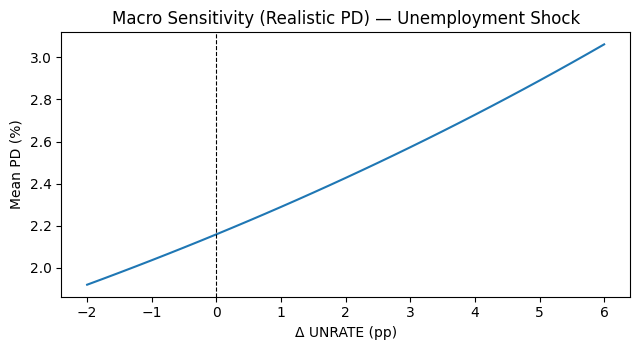

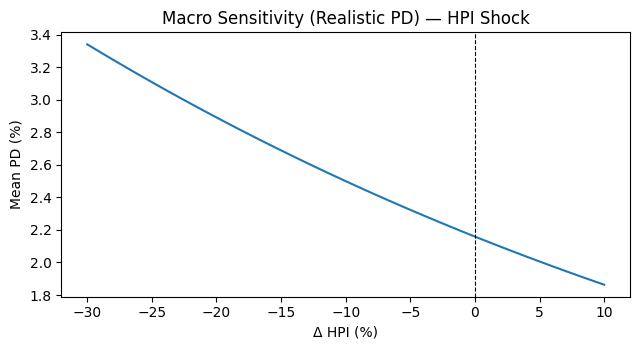

In [ ]:
# Fig 4,5 in report

# helper: sweep a single driver while others = 0
def sweep_driver_curve(p0, su, sh, sr, driver, grid):
    rows = []
    for d in grid:
        delta = {"UNRATE":0.0, "HPI_CHANGE":0.0, "MORTGAGE30US":0.0}
        delta[driver] = d
        p_adj = odds_scaled_pd_adjust_from_probs(p0, delta, su, sh, sr)
        rows.append((d, p_adj.mean()))
    return pd.DataFrame(rows, columns=[driver, "mean_PD"])

# grids in the delta units that were used for scenarios
grid_u = np.linspace(-2, 6, 33)      # -2pp .. +6pp (0.25 steps)
grid_h = np.linspace(-30, 10, 41)    # -30% .. +10% (1% steps)
# grid_r = np.linspace(-1.0, 3.0, 33)  # uncomment to add mortgage rate

df_u = sweep_driver_curve(p_baseline_real, su, sh, sr, "UNRATE", grid_u)
df_h = sweep_driver_curve(p_baseline_real, su, sh, sr, "HPI_CHANGE", grid_h)

plt.figure(figsize=(6.5,3.6))
plt.plot(df_u["UNRATE"], 100*df_u["mean_PD"])
plt.axvline(0, color="k", lw=0.8, ls="--")
plt.title("Macro Sensitivity (Realistic PD) — Unemployment Shock")
plt.xlabel("Δ UNRATE (pp)")
plt.ylabel("Mean PD (%)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5,3.6))
plt.plot(df_h["HPI_CHANGE"], 100*df_h["mean_PD"])
plt.axvline(0, color="k", lw=0.8, ls="--")
plt.title("Macro Sensitivity (Realistic PD) — HPI Shock")
plt.xlabel("Δ HPI (%)")
plt.ylabel("Mean PD (%)")
plt.tight_layout(); plt.show()



In [11]:
import itertools

DRIVERS = ["UNRATE","HPI_CHANGE","MORTGAGE30US"]

def shapley_decomposition(p0, scenario_delta, su, sh, sr):
    """
    Returns a DataFrame with each driver's contribution (in absolute PD points)
    using Shapley-style averaging of marginal effects across all permutations.
    """
    base_mean = float(p0.mean())
    perms = list(itertools.permutations(DRIVERS))
    contribs = {d: 0.0 for d in DRIVERS}

    for perm in perms:
        current_delta = {"UNRATE":0.0,"HPI_CHANGE":0.0,"MORTGAGE30US":0.0}
        prev_mean = base_mean
        for d in perm:
            # add only driver d's scenario shock (others unchanged)
            current_delta[d] = scenario_delta.get(d, 0.0)
            p_adj = odds_scaled_pd_adjust_from_probs(p0, current_delta, su, sh, sr)
            new_mean = float(p_adj.mean())
            contribs[d] += (new_mean - prev_mean)
            prev_mean = new_mean

    # average over permutations
    nperm = len(perms)
    for d in contribs:
        contribs[d] /= nperm

    # assemble output
    total_delta = sum(contribs.values())
    rows = []
    for d in DRIVERS:
        rows.append({
            "driver": d,
            "contribution": contribs[d],
            "share_of_total": (contribs[d]/total_delta) if total_delta else np.nan
        })
    out = pd.DataFrame(rows).sort_values("contribution", ascending=False)
    return out, base_mean, base_mean + total_delta

# Run decomposition for LOW and ADVERSE on both pd bases
for name, base_vec in [("RELATIVE", p_baseline_rel), ("REALISTIC", p_baseline_real)]:
    print(f"\n=== Shapley Decomposition ({name}) ===")
    for scen in ["low","adverse"]:
        dec, base, stressed = shapley_decomposition(base_vec, stress[scen], su, sh, sr)
        print(f"\nScenario: {scen}")
        print(f"Baseline mean PD: {base:.3%}  → Stressed: {stressed:.3%}  (Δ: {stressed-base:+.3%})")
        print(dec.to_string(index=False))



=== Shapley Decomposition (RELATIVE) ===

Scenario: low
Baseline mean PD: 11.123%  → Stressed: 14.244%  (Δ: +3.121%)
      driver  contribution  share_of_total
  HPI_CHANGE      0.015568        0.498798
      UNRATE      0.012444        0.398726
MORTGAGE30US      0.003198        0.102477

Scenario: adverse
Baseline mean PD: 11.123%  → Stressed: 18.841%  (Δ: +7.718%)
      driver  contribution  share_of_total
  HPI_CHANGE      0.035005        0.453572
      UNRATE      0.034972        0.453146
MORTGAGE30US      0.007199        0.093283

=== Shapley Decomposition (REALISTIC) ===

Scenario: low
Baseline mean PD: 2.159%  → Stressed: 2.893%  (Δ: +0.734%)
      driver  contribution  share_of_total
  HPI_CHANGE      0.003658        0.498618
      UNRATE      0.002926        0.398751
MORTGAGE30US      0.000753        0.102631

Scenario: adverse
Baseline mean PD: 2.159%  → Stressed: 4.084%  (Δ: +1.925%)
      driver  contribution  share_of_total
  HPI_CHANGE      0.008724        0.453236
     

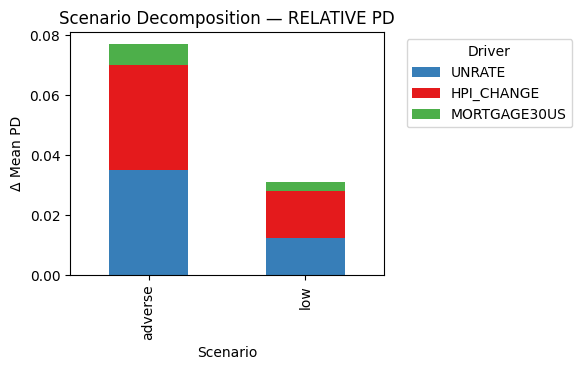

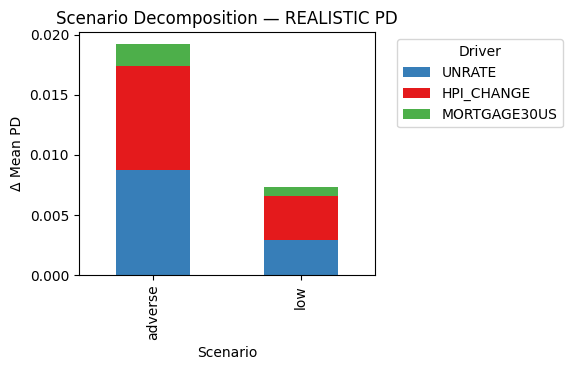

In [ ]:
# Fig 6,7 in report
# Combine both versions in one tidy frame
decomp_rows = []
for name, base_vec in [("RELATIVE", p_baseline_rel), ("REALISTIC", p_baseline_real)]:
    for scen in ["low","adverse"]:
        dec, base, stressed = shapley_decomposition(base_vec, stress[scen], su, sh, sr)
        dec["Scenario"] = scen
        dec["Version"] = name
        decomp_rows.append(dec)

df_dec = pd.concat(decomp_rows, ignore_index=True)

# Plot stacked bars for each version
for name in ["RELATIVE","REALISTIC"]:
    subset = df_dec[df_dec["Version"]==name]
    pivoted = subset.pivot(index="Scenario", columns="driver", values="contribution")
    pivoted = pivoted[["UNRATE","HPI_CHANGE","MORTGAGE30US"]]  # order columns
    pivoted.plot(
        kind="bar",
        stacked=True,
        color=["#377eb8","#e41a1c","#4daf4a"],
        figsize=(6,3.8)
    )
    plt.ylabel("Δ Mean PD")
    plt.title(f"Scenario Decomposition — {name} PD")
    plt.legend(title="Driver", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


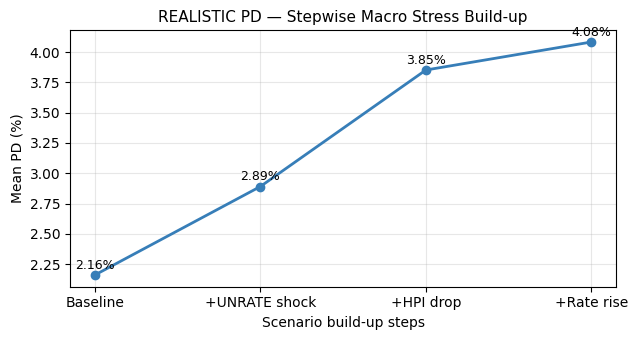

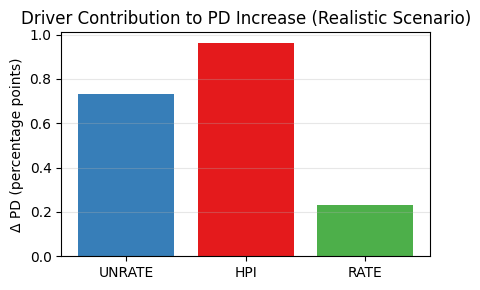

   Driver    Δ_step
1  UNRATE  0.731003
2     HPI  0.962325
3    RATE  0.231517
Stepwise PD build-up (REALISTIC):
           Stage  Mean_PD  Δ_from_base
0       Baseline   0.0216       0.0000
1  +UNRATE shock   0.0289       0.7310
2      +HPI drop   0.0385       1.6933
3     +Rate rise   0.0408       1.9248


In [ ]:
# Stepwise Scenario Build-up (REALISTIC PD only)
# Fig 8 in report

import matplotlib.pyplot as plt
import pandas as pd

def scenario_step_plot(p0, su, sh, sr, du, dh, dr, label="REALISTIC"):
    """
    Show how mean PD increases as macro shocks are added sequentially.
    p0: baseline PD vector (realistic)
    du, dh, dr: changes in UNRATE, HPI_CHANGE, MORTGAGE30US
    """
    base = p0.mean()
    steps = [("Baseline", base)]
    for step, delta in [
        ("+UNRATE shock", {"UNRATE": du}),
        ("+HPI drop", {"UNRATE": du, "HPI_CHANGE": dh}),
        ("+Rate rise", {"UNRATE": du, "HPI_CHANGE": dh, "MORTGAGE30US": dr})
    ]:
        steps.append((step, odds_scaled_pd_adjust_from_probs(p0, delta, su, sh, sr).mean()))
    
    df_steps = pd.DataFrame(steps, columns=["Stage", "Mean_PD"])
    df_steps["Δ_from_base"] = 100 * (df_steps["Mean_PD"] - base)
    
    # Plot
    plt.figure(figsize=(6.5,3.5))
    plt.plot(df_steps["Stage"], 100*df_steps["Mean_PD"], marker="o", linewidth=2, color="#377eb8")
    plt.title(f"{label} PD — Stepwise Macro Stress Build-up", fontsize=11)
    plt.ylabel("Mean PD (%)")
    plt.xlabel("Scenario build-up steps")
    plt.grid(alpha=0.3)
    for i, val in enumerate(df_steps["Mean_PD"]):
        plt.text(i, 100*val + 0.05, f"{100*val:.2f}%", ha="center", fontsize=9)
    plt.tight_layout()
    plt.show()
    
    return df_steps

# Example adverse-type scenario (ΔU=+5pp, ΔH=-20%, ΔRate=+2pp)
df_step_real = scenario_step_plot(p_baseline_real, su, sh, sr, du=5, dh=-20, dr=2, label="REALISTIC")
# Relative contribution by driver (from stepwise PD build-up)
df_contrib = df_step_real.copy()
df_contrib["Δ_step"] = df_contrib["Mean_PD"].diff().fillna(0) * 100
df_contrib = df_contrib.iloc[1:]  # skip baseline
df_contrib["Driver"] = ["UNRATE", "HPI", "RATE"]

plt.figure(figsize=(4.5,3))
plt.bar(df_contrib["Driver"], df_contrib["Δ_step"], color=["#377eb8","#e41a1c","#4daf4a"])
plt.title("Driver Contribution to PD Increase (Realistic Scenario)")
plt.ylabel("Δ PD (percentage points)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(df_contrib[["Driver","Δ_step"]])


print("Stepwise PD build-up (REALISTIC):")
print(df_step_real.round(4))


In [ ]:
# Run before running app.py file, and then type in terminal: streamlit run app.py
# This is only needed if you would like to take a look at a demo website for an interactive dashboard for stress testing
# The description for the website is not included in the report, this is a personal project unrelated to the course GRA4157

from pathlib import Path
import numpy as np

app_dir = Path().resolve()
print("Current notebook directory:", app_dir)

artifacts_dir = app_dir / "artifacts"
artifacts_dir.mkdir(exist_ok=True)

np.savez(
    artifacts_dir / "stress_app_artifacts.npz",
    p_baseline_rel=p_baseline_rel,
    p_baseline_real=p_baseline_real,
    su=su,
    sh=sh,
    sr=sr,
    wu=wu,
    wh=wh,
    wr=wr,
)

print("Saved artifacts to:", (artifacts_dir / "stress_app_artifacts.npz"))
